In [1]:
# Fix randomness and hide warnings
seed = 42
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rc('font', size=16)

2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cp /gdrive/MyDrive/ANN-HOMEWORK2/training_dataset.zip /content/training_dataset.zip
!unzip training_dataset.zip

# Load the data
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

cp: cannot stat '/gdrive/MyDrive/ANN-HOMEWORK2/training_dataset.zip': No such file or directory
Archive:  training_dataset.zip
  inflating: categories.npy          
  inflating: training_data.npy       
  inflating: valid_periods.npy       


In [9]:
from Utils import split_dataset, build_sequences_optimized

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_validation_data, train_validation_labels, test_data, test_labels = split_dataset(dataset, labels)
train_data, train_labels, validation_data, validation_labels = split_dataset(train_validation_data, train_validation_labels)

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
train_data.shape

Dataset shape:  (48000, 200)
Train data shape:  (38400, 200)
Test data shape:  (9600, 200)
Train data shape:  (30720, 200)
Test data shape:  (7680, 200)


(30720, 200, 1)

In [10]:
def augment_data(train_data, train_labels, num_rounds=3):
    num_augmentations=3
    total_size = num_rounds * num_augmentations * len(train_data)

    # Preallocate numpy arrays
    augmented_train_data = np.empty((total_size, *train_data.shape[1:]))
    augmented_train_labels = np.empty((total_size, *train_labels.shape[1:]))

    for round in range(num_rounds):
        print("Augmentation round: ", round)
        for i in range(len(train_data)):
            # Calculate the start index for this round and data point
            start_idx = round * num_augmentations * len(train_data) + i * num_augmentations

            # Add noise
            noise = np.random.normal(0, 0.05, train_data[i].shape)
            augmented_train_data[start_idx] = train_data[i] + noise
            augmented_train_labels[start_idx] = train_labels[i]

            # Add scaling
            scaling = np.random.uniform(0.8, 1.2)
            augmented_train_data[start_idx + 1] = train_data[i] * scaling
            augmented_train_labels[start_idx + 1] = train_labels[i] * scaling

            # Add constant value
            constant = np.random.uniform(-0.1, 0.1)
            augmented_train_data[start_idx + 2] = train_data[i] + constant
            augmented_train_labels[start_idx + 2] = train_labels[i] + constant

    return augmented_train_data, augmented_train_labels

augmented_train_data, augmented_train_labels = augment_data(train_data, train_labels)
# augmented_train_data, augmented_train_labels = augment_data(dataset, labels)
augmented_train_data = augmented_train_data.reshape((augmented_train_data.shape[0], augmented_train_data.shape[1], 1))
augmented_train_labels = augmented_train_labels.reshape((augmented_train_labels.shape[0], augmented_train_labels.shape[1], 1))

# del train_data, train_labels

Augmentation round:  0
Augmentation round:  1
Augmentation round:  2


In [48]:
forecast_steps = 18

def residual_block(x, filters, kernel_size):
    """
    Define a basic residual block for Conv1D-based ResNet.
    """
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet1D_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    x = Conv1D(64, 3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stack residual blocks
    num_blocks = 8 # Modify the number of residual blocks as needed
    for _ in range(num_blocks):
        x = residual_block(x, 64, 3)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(forecast_steps, 3, padding='same')(x)  # Final Conv1D layer for forecasting
    x = Flatten()(x)
    output_layer = Dense(forecast_steps, activation='linear')(x)

    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='resnet1D_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model



Model: "resnet1D_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_67 (Conv1D)          (None, 200, 64)              256       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_62 (Ba  (None, 200, 64)              256       ['conv1d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 200, 64)              0         ['batch_normaliza

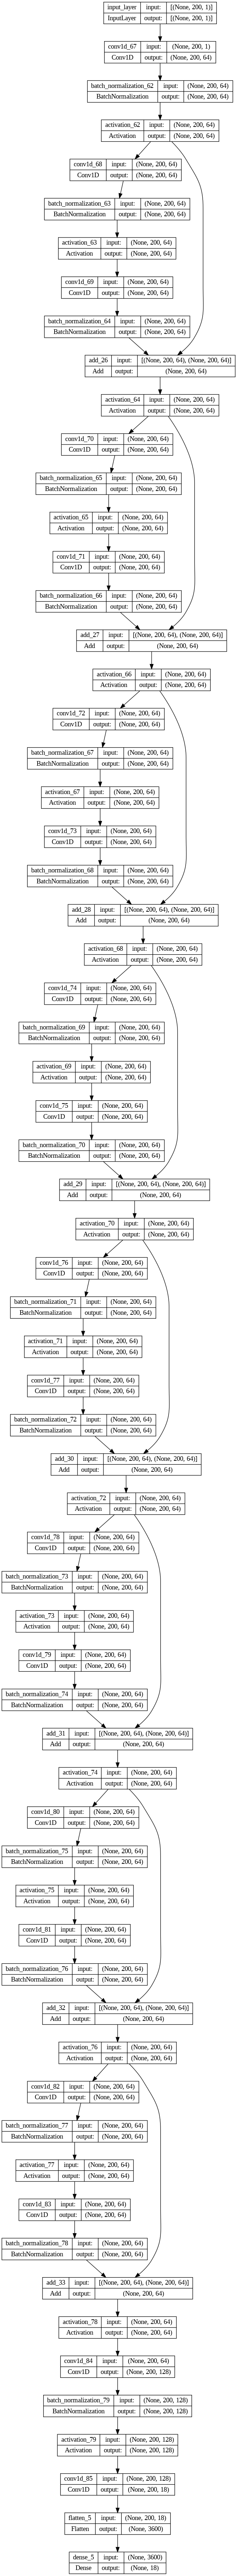

In [56]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Reshape, Flatten, Dense

input_shape = augmented_train_data.shape[1:]
output_shape = augmented_train_labels.shape[1:]
batch_size = 256
epochs = 10

model = build_resnet1D_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [57]:
print(input_shape)

(200, 1)


In [50]:
# Train the model
history = model.fit(
    x = augmented_train_data,
    y = augmented_train_labels,
    batch_size = batch_size,
    epochs = epochs,
    # validation_data=(validation_data, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0003, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/10
1080/1080 [==============================] - 110s 90ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - lr: 0.0010
Epoch 2/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - lr: 0.0010
Epoch 3/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - lr: 0.0010
Epoch 4/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - lr: 0.0010
Epoch 5/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - lr: 0.0010
Epoch 6/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - lr: 0.0010
Epoch 7/10
1080/1080 [==============================] - 97s 90ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - lr: 0.0010
Epoch 8/10
1080/1080 [==============================] - 97s 90ms/step - los

In [51]:
model.save("resnet1D_model.h5")

In [52]:
from Utils import evaluate_model

test_data_predictions = model.predict(test_data)
evaluate_model(test_data_predictions, test_labels)

300/300 [==============================] - 2s 5ms/step
MAE: 0.11851744319727622
MSE: 0.028281441051509378
RMSE: 0.16817086861733627


In [53]:
# Evaluate random samples
evaluate_model(np.random.rand(*test_data_predictions.shape), test_labels)

MAE: 0.3224372890806888
MSE: 0.15588220907167616
RMSE: 0.3948192106162973


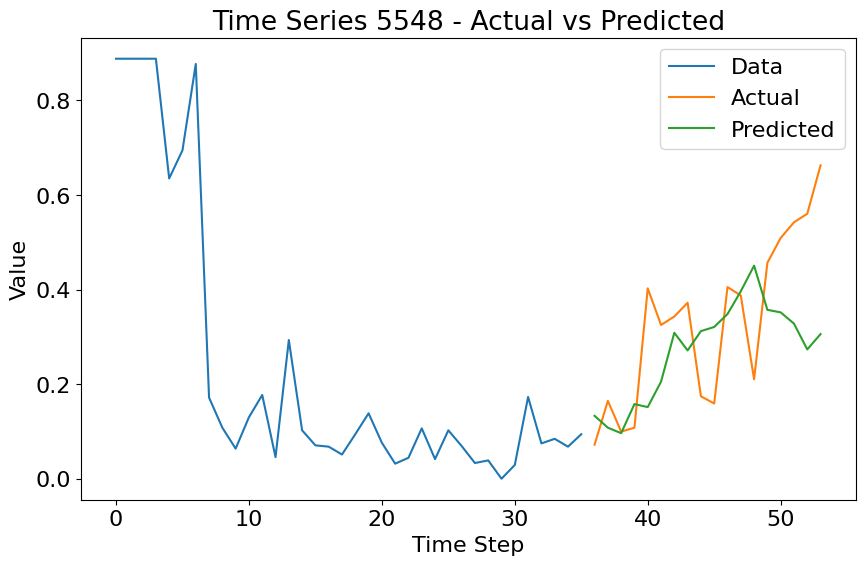

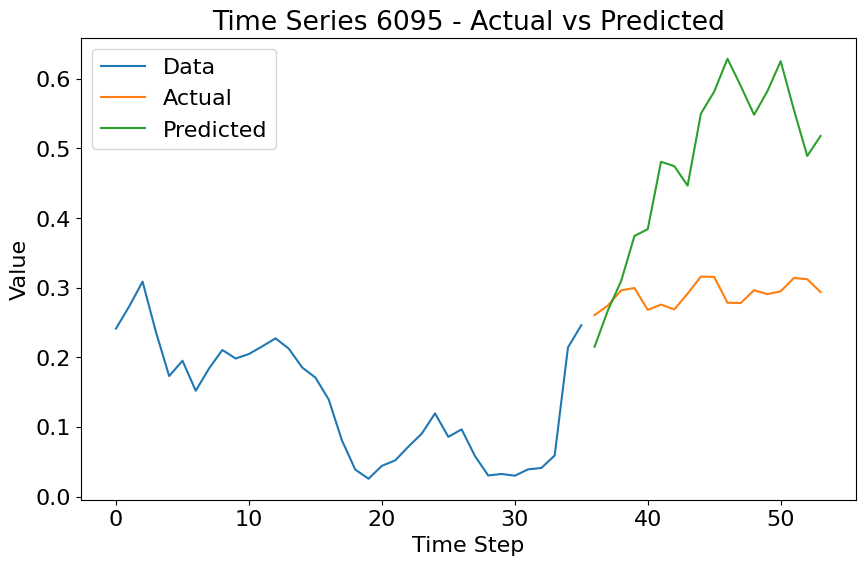

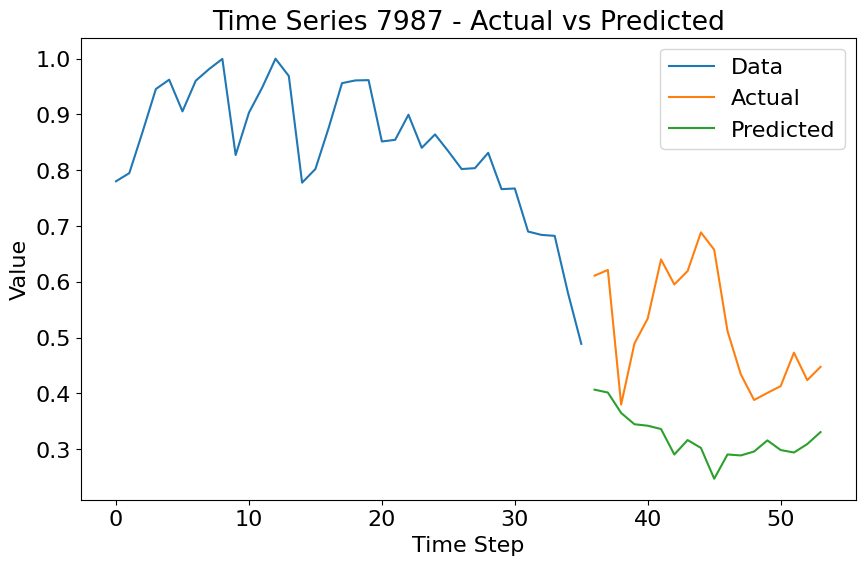

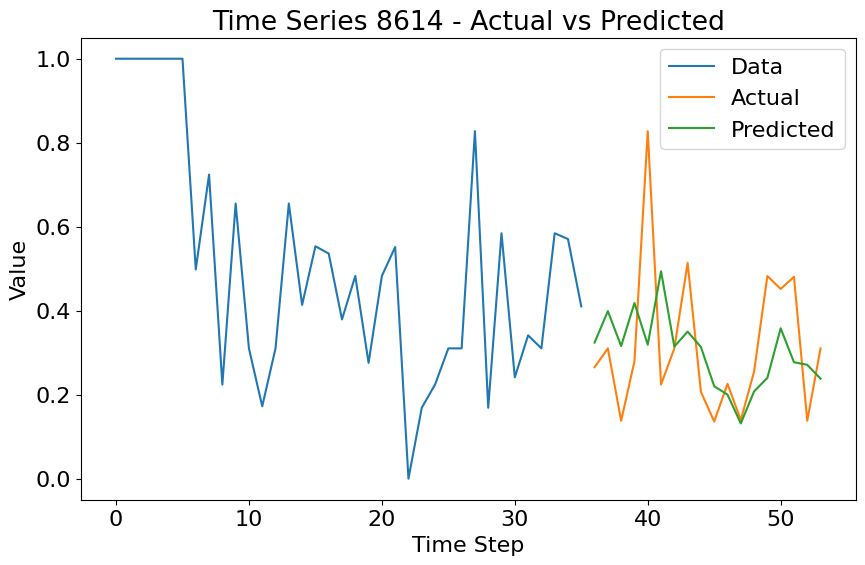

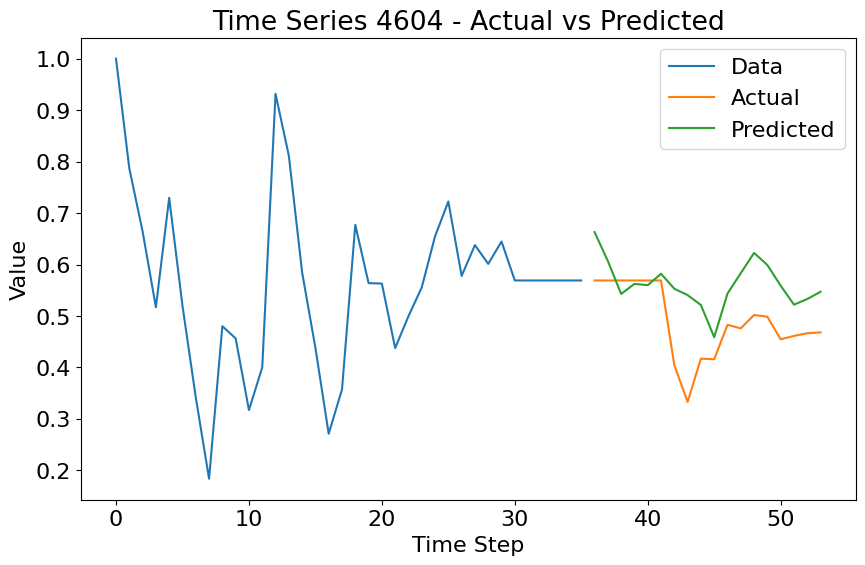

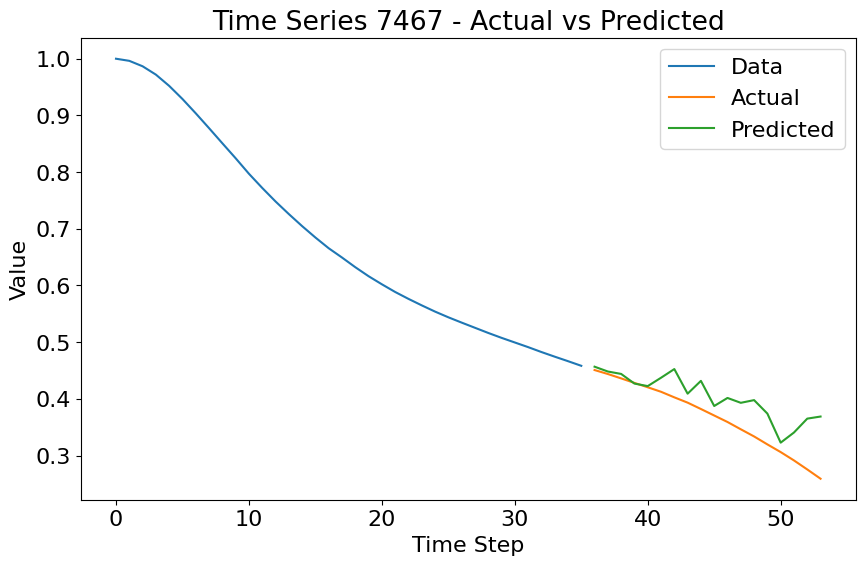

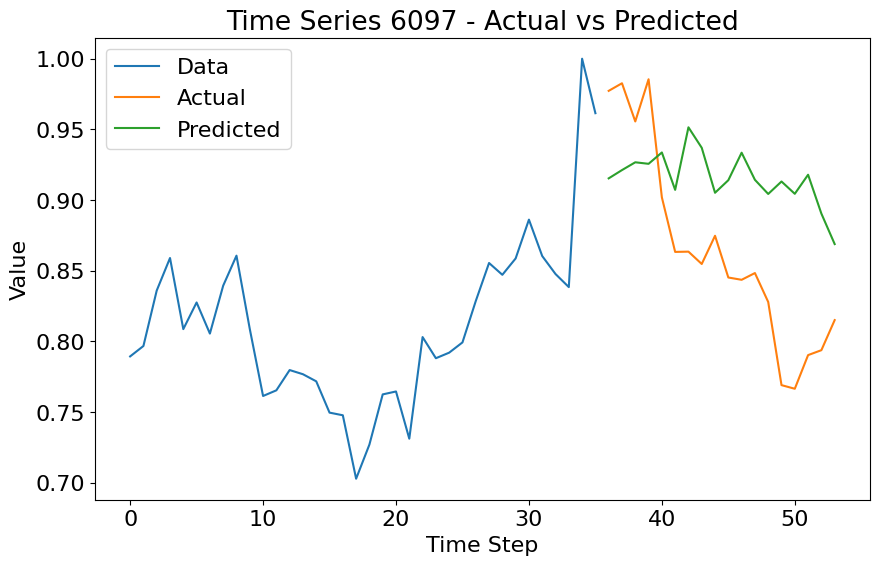

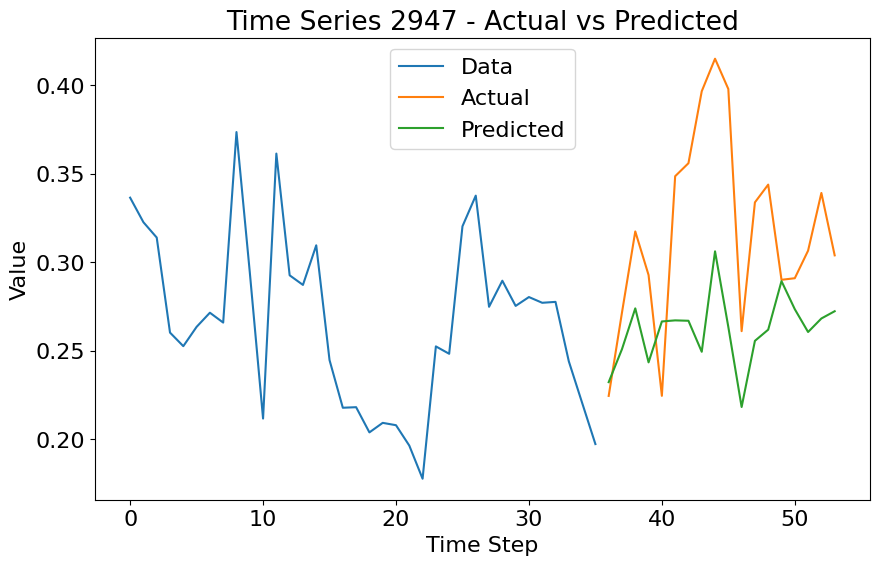

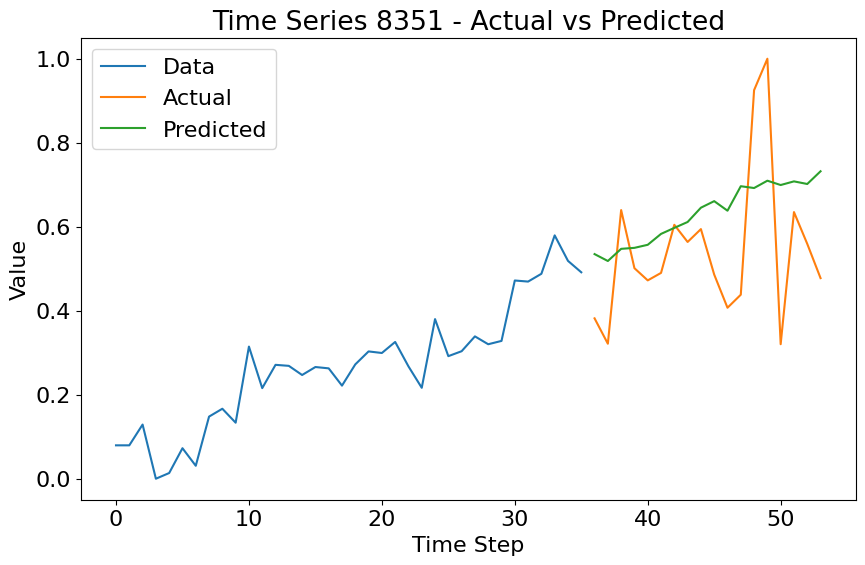

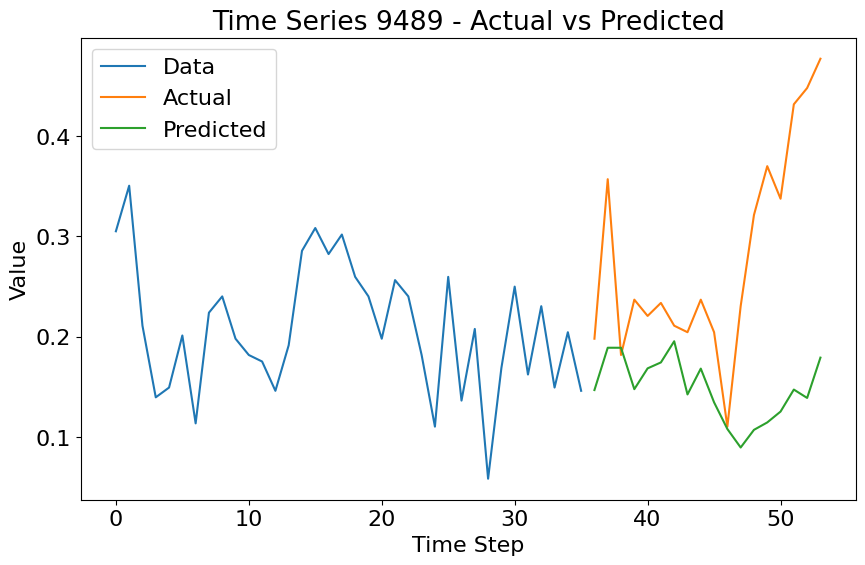

In [54]:
from Utils import plot_predictions
for _ in range(10):
    idx = np.random.randint(0, len(test_data))
    plot_predictions(test_data, test_data_predictions, test_labels,idx)
    # Utils.plot_predictions(train_data, test_data_predictions, train_labels,idx)